# Toy problem

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.set_cmap("viridis")
import numpy as np
import theano
import theano.tensor as T

In [2]:
from carl.distributions import Normal
from carl.distributions import Mixture

components = [
    Normal(mu=-2.0, sigma=0.75), 
    Normal(mu=0.0, sigma=2.0), 
    Normal(mu=1.0, sigma=0.25),
]

g = theano.shared(0.1) 
p0 = Mixture(components=components, weights=[0.5 - g/2.0, 0.5 - g/2.0, g])
p1 = Mixture(components=components[:2], weights=[0.5, 0.5])

/home/gilles/src/carl/carl/distributions/base.py:128: UserWarning: The Param class is deprecated. Replace Param(default=N) by theano.In(value=N)
  [theano.Param(v, name=v.name) for v in args] +
/home/gilles/src/carl/carl/distributions/base.py:128: UserWarning: The Param class is deprecated. Replace Param(default=N) by theano.In(value=N)
  [theano.Param(v, name=v.name) for v in args] +
/home/gilles/src/carl/carl/distributions/base.py:128: UserWarning: The Param class is deprecated. Replace Param(default=N) by theano.In(value=N)
  [theano.Param(v, name=v.name) for v in args] +
/home/gilles/src/carl/carl/distributions/base.py:128: UserWarning: The Param class is deprecated. Replace Param(default=N) by theano.In(value=N)
  [theano.Param(v, name=v.name) for v in args] +
/home/gilles/src/carl/carl/distributions/base.py:128: UserWarning: The Param class is deprecated. Replace Param(default=N) by theano.In(value=N)
  [theano.Param(v, name=v.name) for v in args] +
/home/gilles/src/carl/carl/dis

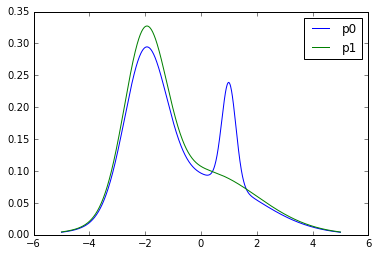

In [3]:
reals = np.linspace(-5, 5, num=1000)
plt.plot(reals, p0.pdf(reals.reshape(-1, 1)), label="p0")
plt.plot(reals, p1.pdf(reals.reshape(-1, 1)), label="p1")
plt.legend(loc="best")
plt.show()

# Direct density ratio estimation with backpropagation

$$\min_R V(R) = \mathbb{E}_{x \sim p_1} [\sqrt{R(x)}] + \mathbb{E}_{x \sim p_0} [\frac{1}{\sqrt{R(x)}}] $$

In [4]:
from keras.models import Sequential
from keras.layers.core import Dense
import keras.backend as K

Using Theano backend.
/home/gilles/src/Theano/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [5]:
R = Sequential()
R.add(Dense(32, input_dim=1, activation='relu'))
R.add(Dense(32, activation='relu'))
R.add(Dense(32, activation='relu'))
R.add(Dense(1))

In [6]:
n_samples = 50000
X0 = p0.rvs(n_samples=n_samples)
X1 = p1.rvs(n_samples=n_samples)
X = np.vstack((X0, X1))
y = np.zeros(len(X)) 
y[len(X0):] = 1

In [7]:
# Note: we solve for exp(R(x)) so that the solution is log(R(x))
#       in this way, we avoid putting positivity constraints

def loss(y_true, y_pred):
#     # Our loss
#     return (y_true * (K.sqrt(K.exp(y_pred))) + 
#             (1.0 - y_true) * (1.0 / K.sqrt(K.exp(y_pred)))) 

    # Sugiyama's loss
    return ((y_true * K.exp(y_pred) ** 2) - 
             2.0 * (1.0 - y_true) * K.exp(y_pred))

R.compile(loss=loss, optimizer="adam")
R.fit(X, y, nb_epoch=10)

Epoch 1/10
100000/100000 [==============================] - 1s - loss: -0.5327     
Epoch 2/10
100000/100000 [==============================] - 1s - loss: -0.5520     
Epoch 3/10
100000/100000 [==============================] - 1s - loss: -0.5549     
Epoch 4/10
100000/100000 [==============================] - 1s - loss: -0.5555     
Epoch 5/10
100000/100000 [==============================] - 1s - loss: -0.5558     
Epoch 6/10
100000/100000 [==============================] - 1s - loss: -0.5569     
Epoch 7/10
100000/100000 [==============================] - 1s - loss: -0.5563     
Epoch 8/10
100000/100000 [==============================] - 1s - loss: -0.5568     
Epoch 9/10
100000/100000 [==============================] - 1s - loss: -0.5572     
Epoch 10/10
100000/100000 [==============================] - 1s - loss: -0.5577     


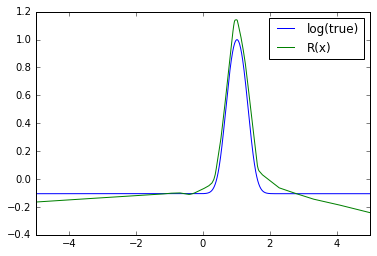

In [8]:
plt.plot(reals, np.log(p0.pdf(reals.reshape(-1, 1)) / 
                       p1.pdf(reals.reshape(-1, 1))), label="log(true)")
plt.plot(reals, R.predict(reals.reshape(-1, 1)), label="R(x)")

plt.xlim(-5, 5)
plt.legend(loc="best")
plt.show()

Bim!

# Transforming adversarial network

$$\min_G \max_D V(G, D) = \mathbb{E}_{x \sim p_0} [\log(1-D(x))] + \mathbb{E}_{x \sim p_1} [\log(D(G(x)))] $$

In [10]:
from carl.distributions import MultivariateNormal
from carl.distributions import Mixture

# p0 = MultivariateNormal(mu=np.array([-2., -2.]), sigma=np.eye(2))
c0 = MultivariateNormal(mu=np.array([-2, 0.]), sigma=0.5*np.eye(2))
c1 = MultivariateNormal(mu=np.array([2, 1.]), sigma=np.eye(2))
p0 = Mixture(components=[c0, c1])

c0 = MultivariateNormal(mu=np.array([-2, -2.]), sigma=0.5*np.eye(2))
c1 = MultivariateNormal(mu=np.array([2, -2.]), sigma=np.eye(2))
p1 = Mixture(components=[c0, c1])

# p1 = Mixture(components=[
#         MultivariateNormal(mu=np.array([0., 0.]), sigma=np.eye(2)),
#         MultivariateNormal(mu=np.array([0., 2.]), sigma=np.eye(2)),
#         MultivariateNormal(mu=np.array([2., 3.]), sigma=np.eye(2))])

X0 = p0.rvs(10000)
X1_0 = c0.rvs(5000)
X1_1 = c1.rvs(5000)
X1 = np.vstack((X1_0, X1_1))

/home/gilles/src/carl/carl/distributions/base.py:128: UserWarning: The Param class is deprecated. Replace Param(default=N) by theano.In(value=N)
  [theano.Param(v, name=v.name) for v in args] +
/home/gilles/anaconda3/envs/keras/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: stack(*tensors) interface is deprecated, use stack(tensors, axis=0) instead.
/home/gilles/anaconda3/envs/keras/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: stack(*tensors) interface is deprecated, use stack(tensors, axis=0) instead.


In [15]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
import keras.backend as K

In [17]:
D = Sequential()
D.add(Dense(12, input_dim=X0.shape[1], activation=LeakyReLU()))
D.add(Dropout(0.1))
D.add(Dense(12, input_dim=12, activation=LeakyReLU()))
D.add(Dropout(0.1))
D.add(Dense(12, input_dim=12, activation=LeakyReLU()))
D.add(Dropout(0.1))
D.add(Dense(12, input_dim=12, activation=LeakyReLU()))
D.add(Dropout(0.1))
D.add(Dense(1, input_dim=12, activation='sigmoid'))

def loss_D(y_true, y_pred):
    return -((1.0 - y_true) * (K.log(1.0 - y_pred)) + 
             (y_true) * (K.log(y_pred)))  

In [18]:
from keras.regularizers import Regularizer
from keras.layers import Highway

class MappingRegularizer(Regularizer):
    def __init__(self, G, l1=0., l2=0.):
        self.G = G
        self.l1 = l1
        self.l2 = l2

    def set_layer(self, layer):
        self.layer = layer

    def __call__(self, loss):
        x = self.G.get_input(True)
        Gx = self.layer.get_output(True)
        loss += self.l1 * K.mean(K.abs(x - Gx))
        loss += self.l2 * K.mean(K.square(x - Gx))
        return loss

    def get_config(self):
        return {"name": self.__class__.__name__,
                "l1": self.l1,
                "l2": self.l2}

G = Sequential()
G.add(Dense(12, input_dim=X0.shape[1], activation=LeakyReLU()))
G.add(Dropout(0.1))
G.add(Dense(12, input_dim=12, activation=LeakyReLU()))
G.add(Dropout(0.1))
G.add(Dense(12, input_dim=12, activation=LeakyReLU()))
G.add(Dropout(0.1))
G.add(Dense(12, input_dim=12, activation=LeakyReLU()))
G.add(Dropout(0.1))
G.add(Dense(X0.shape[1], input_dim=8, activation='linear', 
            activity_regularizer=MappingRegularizer(G, l2=0.0, l1=0.0)))
G.compile(loss="mse", optimizer="sgd")  

GD = Sequential()
GD.add(G)
D.trainable = False
GD.add(D)

def loss_GD(y_true, y_pred):
    return y_true * (K.log(y_pred))

In [19]:
C = Sequential()
C.add(Dense(12, input_dim=X0.shape[1], activation=LeakyReLU()))
G.add(Dropout(0.1))
C.add(Dense(12, input_dim=12, activation=LeakyReLU()))
G.add(Dropout(0.1))
C.add(Dense(12, input_dim=12, activation=LeakyReLU()))
G.add(Dropout(0.1))
C.add(Dense(12, input_dim=12, activation=LeakyReLU()))
G.add(Dropout(0.1))
C.add(Dense(1, input_dim=12, activation='sigmoid'))

GC = Sequential()
GC.add(G)
C.trainable = False
GC.add(C)

def loss_GC(y_true, y_pred):
    return -((1.0 - y_true) * (K.log(1.0 - y_pred)) + 
             (y_true) * (K.log(y_pred)))  

In [20]:
D.compile(loss=loss_D, optimizer="sgd")
C.compile(loss=loss_GC, optimizer="sgd")
GD.compile(loss=loss_GD, optimizer="sgd")
GC.compile(loss=loss_GC, optimizer="sgd")

In [21]:
from keras.callbacks import Callback

class LossHistory(Callback):
    def __init__(self):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [22]:
# Pretrain D
X = np.vstack((X0, G.predict(X1)))
print(X.shape)
y = np.zeros(len(X))
y[len(X0):] = 1
D.fit(X, y, nb_epoch=50, verbose=0)

(20000, 2)


In [23]:
# Pretrain C
X = np.vstack((G.predict(X1_0), G.predict(X1_1)))
print(X.shape)
y = np.zeros(len(X))
y[len(X1_0):] = 1
C.fit(X, y, nb_epoch=50, verbose=0)

(10000, 2)


In [24]:
def plot_distribution(D, G, X0, X1):
    if X0.shape[1] == 1:
        plt.hist(X0, bins=100, range=(-5, 5), alpha=0.5, color="b", label="x~p0", normed=1)
        plt.hist(X1, bins=100, range=(-5, 5), alpha=0.5, color="r", label="x~p1", normed=1)
        plt.hist(G.predict(X1), bins=100, range=(-5, 5), alpha=0.5, color="g", label="G(x), x~p1", normed=1)

        reals = np.linspace(-5, 5, num=1000)
        plt.plot(reals, D.predict(reals.reshape(-1, 1)), label="D(x)")

        plt.xlim(-5, 5)
        plt.ylim(0, 1)
        plt.legend(loc="best")
        plt.show()

    elif X0.shape[1] >= 2:
        plt.hist2d(X0[:, 0], X0[:, 1], bins=30, range=[[-5,5],[-5,5]], normed=1)
        plt.title("x~p0")
        plt.show()

        plt.hist2d(X1[:, 0], X1[:, 1], bins=30, range=[[-5,5],[-5,5]], normed=1)
        plt.title("x~p1")
        plt.show()

        GX = G.predict(X1)
        plt.hist2d(GX[:, 0], GX[:, 1], bins=30, range=[[-5,5],[-5,5]], normed=1)
        plt.title("G(x), x~p1")
        plt.show()

In [25]:
def plot_transform(G, X0, X1):
    if X0.shape[1] == 1:
        reals = np.linspace(-5, 5, num=1000)
        plt.plot(reals, G.predict(reals.reshape(-1, 1)), label="G(x)")
        plt.hlines(0.0, -5, 5, linestyles="dashed")
        plt.vlines(0.0, -5, 5, linestyles="dashed")
        plt.legend()
        plt.show()
        
        X = np.linspace(-5, 5, num=10)
        GX = G.predict(X.reshape(-1, 1)).ravel()
        plt.quiver(X, np.zeros(X.shape),
                   GX - X, np.ones(X.shape),
                   scale_units='xy', angles='xy', scale=1, alpha=0.5)
        plt.ylim(-0.1, 1.1)
        plt.hlines(0.0, -5, 5, linestyles="dashed")
        plt.hlines(1.0, -5, 5, linestyles="dashed")
        plt.show()
        
    elif X0.shape[1] >= 2:
        X, Y = np.meshgrid(np.linspace(-5, 5, num=15), np.linspace(-5, 5, num=15))
        Z = G.predict(np.hstack((X.ravel().reshape(-1, 1), Y.ravel().reshape(-1, 1))))
        GX = Z[:, 0].reshape(X.shape) - X
        GY = Z[:, 1].reshape(Y.shape) - Y
        plt.quiver(X, Y, GX, GY,  scale_units='xy', angles='xy', scale=1, alpha=0.3)

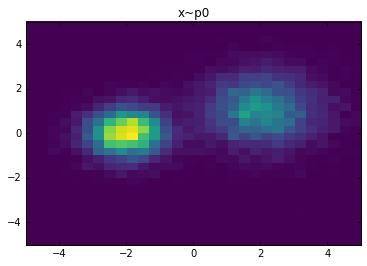

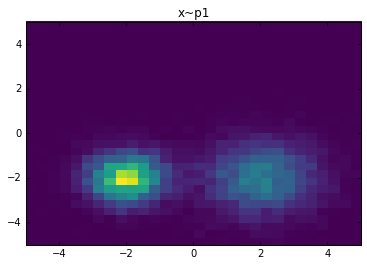

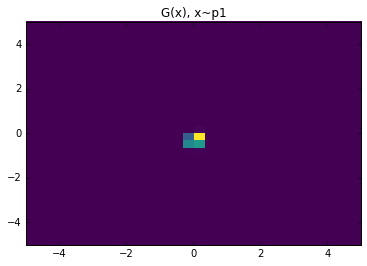

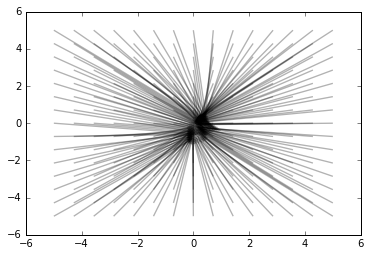

In [26]:
plot_distribution(D, G, X0, X1)
plot_transform(G, X0, X1)

In [ ]:
batch_size = 32

logs_D = LossHistory()
logs_C = LossHistory()
logs_GD = LossHistory()
logs_GC = LossHistory()

y_D = np.zeros(batch_size)
y_D[batch_size // 2:] = 1
y_GD = np.ones(batch_size)
y_C = np.zeros(batch_size)
y_C[batch_size // 2:] = 1
y_GC = y_C

for i in range(100000):
    if i % 250 == 0: print(i)
    
    # fit D 
    indices0 = np.random.permutation(len(X0))
    indices1 = np.random.permutation(len(X1))
    X = np.vstack((X0[indices0[:batch_size // 2]],
                   G.predict(X1[indices1[:batch_size // 2]])))
    D.fit(X, y_D, nb_epoch=3, verbose=0, callbacks=[logs_D])
    
    # fit C 
    indices0 = np.random.permutation(len(X1_0))
    indices1 = np.random.permutation(len(X1_1))
    X = np.vstack((G.predict(X1_0[indices0[:batch_size // 2]]),
                   G.predict(X1_1[indices1[:batch_size // 2]])))
    C.fit(X, y_C, nb_epoch=3, verbose=0, callbacks=[logs_C])
    
    # fit GD   
    indices1 = np.random.permutation(len(X1))
    X = X1[indices1[:batch_size]]
    GD.fit(X, y_GD, nb_epoch=1, verbose=0, callbacks=[logs_GD])
    
    # fit GC
    indices0 = np.random.permutation(len(X1_0))
    indices1 = np.random.permutation(len(X1_1))
    X = np.vstack((X1_0[indices0[:batch_size // 2]],
                   X1_1[indices1[:batch_size // 2]]))
    GC.fit(X, y_GC, nb_epoch=1, verbose=0, callbacks=[logs_GC])

0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000
5250
5500
5750
6000
6250
6500
6750
7000
7250
7500
7750
8000
8250
8500
8750
9000
9250
9500
9750
10000
10250
10500
10750
11000

In [ ]:
plot_distribution(D, G, X0, X1)
plot_transform(G, X0, X1)

In [ ]:
G0 = G.predict(X1_0)
G1 = G.predict(X1_1)
plt.scatter(G0[:, 0], G0[:, 1], marker="x", color="r", label="0", alpha=0.3)
plt.scatter(G1[:, 0], G1[:, 1], marker="x", color="b", label="1", alpha=0.3)
plt.legend()
plt.show()

In [ ]:
# we should evaluate on validation!
plt.plot(list(range(len(logs_D.losses)))[:10000], np.array(logs_D.losses)[:10000], label="D")
plt.plot(list(range(len(logs_C.losses)))[:10000], np.array(logs_C.losses)[:10000], label="C")
plt.legend()
plt.ylim(0, 1)
plt.plot()

In [ ]:
plt.plot(list(range(len(logs_GC.losses)))[:10000], np.array(logs_GC.losses)[:10000], label="GC")
plt.plot(list(range(len(logs_GD.losses)))[:10000], np.array(logs_GD.losses)[:10000], label="GD")
plt.legend()
plt.ylim(-1, 1)
plt.plot()

In [397]:
X0 = p0.rvs(20000)
X1 = p1.rvs(20000)
X_test = np.vstack((X0, G.predict(X1)))
y_test = np.zeros(len(X_test))
y_test[len(X0):] = 1

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
cross_val_score(ExtraTreesClassifier(n_estimators=500), X_test, y_test)

array([ 0.5299985 ,  0.52144893,  0.52820282])

# Ideas

- Combine multiple transformations (reduction of bias/variance?)
- Regularization
- Network architecture of G
- Increase complexity of D over training?